In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from keras import Sequential, layers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
def parse_classes(directory):
    """
    Get the classes of a dataset directory as a vector of strings.
    """
    return sorted([
        d for d in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, d))
    ])

def parse_dataset(directory):
    # Dataset object structure: image -> class
    dataset = {}
    classes = parse_classes(directory)

    # Directory structure: directory -> class_directory -> image
    for i, cls in enumerate(classes):
        cls_dir = os.path.join(directory, cls)
        for img in os.listdir(cls_dir):
            img = os.path.join(cls_dir, img)
            dataset[img] = i

    return dataset

In [12]:
train_dir = os.path.expanduser('~/datasets/fruits-360/Training')
test_dir = os.path.expanduser('~/datasets/fruits-360/Test')
img_size = (100, 100)
channels = 3  # RGB
epochs = 5
batch_size = 64

In [13]:
train_generator = ImageDataGenerator(rescale=1/255,
                                    # Rotate the images
                                    rotation_range=40,
                                    # Cut the images
                                    shear_range=0.2,
                                    # Zoom the images
                                    zoom_range=0.2,
                                    # Flip the images
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_generator = ImageDataGenerator(rescale = 1/255)

In [14]:
classes = parse_classes(train_dir)

In [15]:
train_data = train_generator.flow_from_directory(train_dir,
                                                 target_size=img_size,
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

test_data = test_generator.flow_from_directory(test_dir,
                                               target_size=img_size,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [36]:
model = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(*img_size, channels)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(*img_size, channels)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(units=100, activation='sigmoid'),
    layers.Dropout(0.15),
    layers.Dense(units=200, activation='sigmoid'),
    layers.Dropout(0.15),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

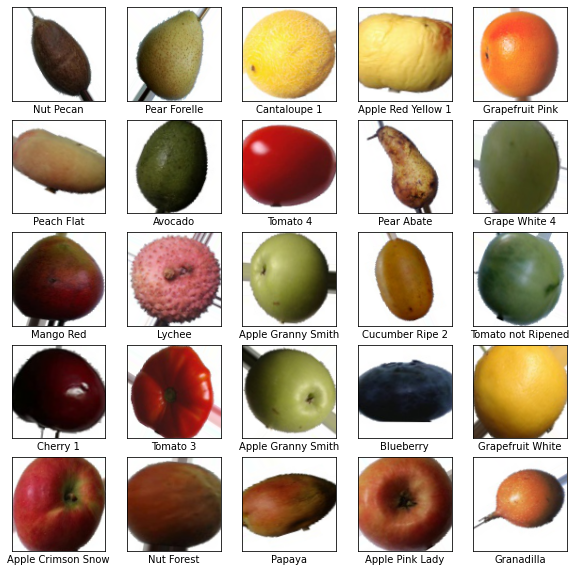

In [27]:
plt.figure(figsize=(10,10))
batch = train_data.next()

for i in range(min(25, len(batch[0]))):
    img = batch[0][i]
    label = classes[np.argmax(batch[1][i])]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(label)

plt.show()
# plt.savefig('/home/blacklight/fruit-360-1.png')

In [37]:
history = model.fit_generator(
    generator=train_data,
    steps_per_epoch=train_data.samples/batch_size,
    validation_data=test_data,
    validation_steps=test_data.samples/batch_size,
    epochs=epochs
)

Epoch 1/5
1058/1057 [==============================] - 859s 812ms/step - loss: 2.6444 - accuracy: 0.3622 - val_loss: 1.5080 - val_accuracy: 0.7355

In [46]:
model.evaluate(test_data)

    924/Unknown - 366s 396ms/step - loss: 0.1689 - accuracy: 0.9587

KeyboardInterrupt: 

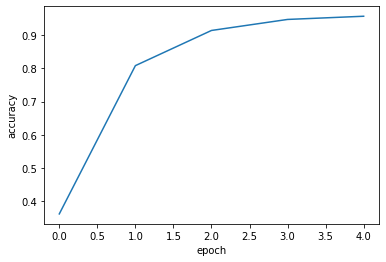

In [40]:
epochs = history.epoch
accuracy = history.history['accuracy']

fig = plt.figure()
plot = fig.add_subplot()
plot.set_xlabel('epoch')
plot.set_ylabel('accuracy')
plot.plot(epochs, accuracy)

In [36]:
test_batch = test_data.next()
test_images = test_batch[0]
test_labels = test_batch[1]
predictions = model.predict(test_images)

In [39]:
test_img = test_images[0]
expected_class = classes[np.argmax(test_labels[0])]
predicted_class = classes[np.argmax(model.predict(np.asarray([test_img])))]
print(f'Expected class: {expected_class}. Predicted class: {predicted_class}')

Expected class: Apple Crimson Snow. Predicted class: Apple Crimson Snow


In [43]:
def plot_image_and_predictions(prediction, classes, true_label, img):
    import numpy as np
    import matplotlib.pyplot as plt

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = int(np.argmax(prediction))
    confidence = 100 * np.max(prediction)
    color = 'blue' if predicted_label == true_label else 'red'

    plt.xlabel('{predicted} {confidence:2.0f}% ({expected})'.format(
        predicted=classes[predicted_label],
        confidence=confidence,
        expected=classes[int(true_label)]), color=color)

def plot_value_array(prediction, true_label):
    import numpy as np
    import matplotlib.pyplot as plt

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(len(prediction)), prediction, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(prediction)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
def plot_results(images, labels, predictions, classes, rows, cols):
    n_images = rows * cols
    plt.figure(figsize=(2 * 2 * cols, 2 * rows))

    for i in range(n_images):
        plt.subplot(rows, 2 * cols, 2 * i + 1)
        plot_image_and_predictions(predictions[i], classes, labels[i], images[i])
        plt.subplot(rows, 2 * cols, 2 * i + 2)
        plot_value_array(predictions[i], labels[i])

    #plt.savefig('/home/blacklight/fruit-360-evaluation.png')
    plt.show()

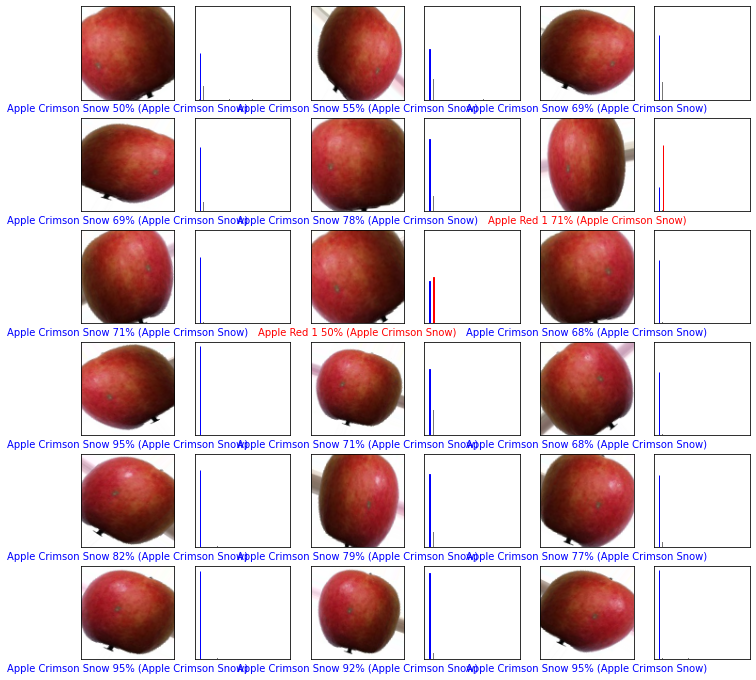

In [44]:
plot_results(
    images=test_images,
    labels=[np.argmax(label_values) for label_values in test_labels],
    classes=classes,
    predictions=predictions,
    rows=6, cols=3)

In [5]:
def model_save(model, model_dir, labels, overwrite=True):
    import json
    import os

    # Create the model directory if it doesn't exist
    os.makedirs(model_dir, exist_ok=True)

    # The TensorFlow model save won't keep track of the labels of your model.
    # It's usually a good practice to store them in a separate JSON file.
    labels_file = os.path.join(model_dir, 'labels.json')
    with open(labels_file, 'w') as f:
        f.write(json.dumps(list(labels)))

    # Then, save the TensorFlow model using the save primitive
    model_file = os.path.join(model_dir, 'model.pb')
    model.save(model_file, overwrite=overwrite)


model_dir = os.path.expanduser('~/models/fruits-360')

In [68]:
model_save(model, model_dir, labels=classes)

In [3]:
def model_load(model_dir):
    import json
    import os
    from tensorflow.keras.models import load_model

    labels = []
    labels_file = os.path.join(model_dir, 'labels.json')

    if os.path.isfile(labels_file):
        with open(labels_file) as f:
            labels = json.load(f)

    model_file = os.path.join(model_dir, 'model.pb')
    m = load_model(model_file)
    return m, labels

In [6]:
model, labels = model_load(model_dir)
